# Study of age, metallicity and extra-tidal region of a globular cluster NGC 4147

1) The aim of this project is to study the age, metallicity, and extra-tidal region of **NGC 4147** using data from Gaia DR3. 
2) Identify extra-tidal candidates based on cluster and stellar proper motions, and their positions on the color–magnitude diagram.
3) Analyze the spatial distribution of these stars to understand the cluster’s dynamical history within the Milky Way.



## Notebook Workflow  
**1)** [Introducing Globular Clusters](#h1)  <br>
**2)** [Problem Statement](#h2)  <br>
**3)** [Data Acquisition](#h3)  <br>
**4)** [Data Analysis and Methodology](#h4)  <br>
&emsp;‣ [4.1 Data Reduction](#h41)  <br>
&emsp;‣ [4.2 Proper Motion Selection](#h42)  <br>
&emsp;‣ [4.3 Membership Probability](#h43)  <br>
&emsp;‣ [4.4 Color-Magnitude Diagram](#h44)  <br>
&emsp;‣ [4.5 Isochrone Fitting](#h45)  <br>
&emsp;‣ [4.6 Density Map](#h46)  <br>
&emsp;‣ [4.7 Orbit of the Cluster](#h47)  <br>
**5)** [Conclusions](#h5)


## What Are Globular Clusters? <a name = 'h1'><a>

**Globular clusters** are tightly bound, spherical groups of stars that orbit the Milky Way and other galaxies.  
Each cluster typically contains **10⁴ to 10⁶ stars**, packed into a compact volume spanning **a few dozen to several hundred light-years** in diameter.

Key properties of globular clusters:
- Composed of **very old stars** (ages ~10–13 billion years)  
- **Metal-poor**, indicating formation in the early universe  
- Found primarily in the **Galactic halo**, distributed spherically around the Galactic center  
- Stars are **gravitationally bound** and highly concentrated toward the cluster core

Globular clusters serve as important tools for:
- Studying the **formation and evolution** of the Milky Way  
- Testing models of **stellar evolution**  
- Tracing the **mass distribution** of the Galaxy, including dark matter

They appear as ancient, brilliant “stellar islands” orbiting the Milky Way.

<img src="https://dq0hsqwjhea1.cloudfront.net/Milky-Way-anatomy-NASA_JPL_Caltech-_-right-_-ESA-_layout-_-ESA-slash-ATG-medialab.jpg" width="55%">

---

## NGC 4147

**NGC 4147** is a remote and metal-poor globular cluster located in the constellation **Coma Berenices**.  
It has the following characteristics:

- **[Fe/H] = −1.78** (low metallicity)  
- **Apparent magnitude**: 10.7  
- **Distance**: ~18.5 kiloparsecs from the Sun  
- **Galactic latitude**: 77.2° → deep in the halo

<img src="https://cdn.esahubble.org/archives/images/screen/heic1905c.jpg" width="40%">

NGC 4147 is notable for its likely association with the **Sagittarius tidal stream**, a stellar stream formed by the disruption of the **Sagittarius Dwarf Spheroidal Galaxy**. This suggests it may have been **captured** by the Milky Way during a past galactic merger.

<img src="https://www.universetoday.com/article_images/sgrstream-768x577-1.jpeg" width="40%">


## Problem Statement <a name = 'h2'><a>

We will be estimating the age and metallicity of the globular cluster NGC 4147 using **color-magnitude diagram** and **isochrone fitting**. The selection of possible extra-tidal candidates will be done on the basis of **proper motion selection**, **membership probabilities**, and study of color-magnitude diagram (CMD) of our cluster. Furthermore, we will be plotting the **density map** for the selected extra-tidal stars and will compute the **orbit** of our cluster. 

## Data Acquisition <a name = 'h3'><a>

Obtaining the raw data sample from Gaia DR3 using the Astronomical Data Query Language (ADQL).

In [1]:
! pip install astroquery

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from astroquery.gaia import Gaia
from astropy.table import Table
from itertools import chain
import pandas as pd

In [3]:
!pip install astroquery pandas

To select astrometrically well-behaved sources, we applied the criteria as recommended in the data release documentation and literature.

In [4]:
# Define the ADQL query
query = """
SELECT source_id, ra, dec, parallax, pmra, pmdec, pmra_error, pmdec_error, ruwe,
       astrometric_excess_noise_sig, astrometric_gof_al, visibility_periods_used,
       phot_bp_rp_excess_factor, bp_rp, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE ruwe < 1.4
AND astrometric_excess_noise_sig <= 2
AND astrometric_gof_al < 3
AND visibility_periods_used > 10
AND 1=CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 182.53, 18.54, 0.505))
"""

job = Gaia.launch_job_async(query)
results = job.get_results()

df = results.to_pandas()

df.to_csv("NGC4147_gaia_dr3.csv", index=False)
print("Download complete. Data saved as 'NGC4147_gaia_dr3.csv'.")

INFO: Query finished. [astroquery.utils.tap.core]
Download complete. Data saved as 'NGC4147_gaia_dr3.csv'.


In [5]:
df = pd.read_csv("NGC4147_gaia_dr3.csv")

print(df.info(5))
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SOURCE_ID                     2389 non-null   int64  
 1   ra                            2389 non-null   float64
 2   dec                           2389 non-null   float64
 3   parallax                      2389 non-null   float64
 4   pmra                          2389 non-null   float64
 5   pmdec                         2389 non-null   float64
 6   pmra_error                    2389 non-null   float64
 7   pmdec_error                   2389 non-null   float64
 8   ruwe                          2389 non-null   float64
 9   astrometric_excess_noise_sig  2389 non-null   float64
 10  astrometric_gof_al            2389 non-null   float64
 11  visibility_periods_used       2389 non-null   int64  
 12  phot_bp_rp_excess_factor      2254 non-null   float64
 13  bp_

In [6]:
def correct_flux_excess_factor(bp_rp, phot_bp_rp_excess_factor):
    """
    Calculate the corrected flux excess factor for the input Gaia EDR3 data.

    Parameters
    ----------
    bp_rp : float or array_like
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    phot_bp_rp_excess_factor : float or array_like
        The flux excess factor listed in the Gaia EDR3 archive.

    Returns
    -------
    float or np.ndarray
        The corrected value for the flux excess factor, which is zero for "normal" stars.

    Example
    -------
    phot_bp_rp_excess_factor_corr = correct_flux_excess_factor(bp_rp, phot_bp_rp_excess_factor)
    """

    bp_rp = np.asarray(bp_rp, dtype=np.float64)
    phot_bp_rp_excess_factor = np.asarray(phot_bp_rp_excess_factor, dtype=np.float64)

    if bp_rp.shape != phot_bp_rp_excess_factor.shape:
        raise ValueError("Function parameters must be of the same shape!")

    # Define correction conditions
    do_not_correct = np.isnan(bp_rp)
    bluerange = np.logical_not(do_not_correct) & (bp_rp < 0.5)
    greenrange = np.logical_not(do_not_correct) & (bp_rp >= 0.5) & (bp_rp < 4.0)
    redrange = np.logical_not(do_not_correct) & (bp_rp > 4.0)

    # Initialize correction array
    correction = np.zeros_like(bp_rp)

    # Apply correction formulas based on bp_rp range
    correction[bluerange] = (
        1.154360 + 0.033772 * bp_rp[bluerange] +
        0.032277 * np.power(bp_rp[bluerange], 2)
    )

    correction[greenrange] = (
        1.162004 + 0.011464 * bp_rp[greenrange] +
        0.049255 * np.power(bp_rp[greenrange], 2) -
        0.005879 * np.power(bp_rp[greenrange], 3)
    )

    correction[redrange] = (
        1.057572 + 0.140537 * bp_rp[redrange]
    )

    # Return corrected excess factor
    return phot_bp_rp_excess_factor - correction

In [7]:
# Load the Gaia DR3 data
df = pd.read_csv("NGC4147_gaia_dr3.csv")

# Apply the correction
df["phot_bp_rp_excess_factor_corr"] = correct_flux_excess_factor(df["bp_rp"], df["phot_bp_rp_excess_factor"])

df.to_csv("NGC4147_gaia_dr3_corrected.csv", index=False)
print(df.head())

             SOURCE_ID          ra        dec  parallax      pmra     pmdec  \
0  3950102725170058880  182.549859  18.539132 -1.875125 -2.066131 -0.994648   
1  3950102725172877824  182.539023  18.533168  0.337589 -2.165506 -2.731644   
2  3950102931327879040  182.556507  18.556774 -0.254678 -1.910701 -2.036851   
3  3950149694931821312  182.485128  18.570416  0.423120 -1.926746 -1.412548   
4  3950149694931929984  182.472899  18.572690 -1.330337  1.207729 -2.082758   

   pmra_error  pmdec_error      ruwe  astrometric_excess_noise_sig  \
0    1.095702     0.872899  1.068895                      1.436060   
1    0.854342     0.599843  1.111584                      1.970729   
2    0.615011     0.467600  0.971750                      0.000000   
3    0.729234     0.675337  1.053781                      1.755422   
4    1.248144     0.811114  0.928845                      0.000000   

   astrometric_gof_al  visibility_periods_used  phot_bp_rp_excess_factor  \
0            1.402512       

## Data analysis and Methodology <a name = 'h4'><a>

### Data Reduction <a name = 'h41'><a>

We began our analysis by selecting only those stars which seemed to be the cluster members.
To obtain these possible members, we selected stars based on the following
criteria:
1) Proper motion of the star consistent with the proper motion of the cluster.
2) Consistent with the selection based on the membership probabilities.
3) Location in the color-magnitude diagram (CMD) consistent with the CMD of the cluster.

Only stars that met the mentioned criteria were considered probable members of the cluster.
- These criteria were applied to all stars located within a radius extending up to five times the tidal radius ($r_{t}$) of the cluster.
- Stars positioned between $r_{t}$ and $5r_{t}$ from the center of the cluster were identified as **extra-tidal candidates** for further analysis.
- For this study, the adopted value of $r_{t}$ is 6.6 arcmin. 

### Proper Motion Selection <a name = 'h42'><a>

### Proper Motion
It is the apparent angular motion of a star across the sky with respect to more distant stars.
<img src="https://www.astronomy.ohio-state.edu/pogge.1/Ast162/Unit1/Images/space.gif" width="40%">
---
Representation of pmra ($\mu_{\alpha} \cos {\delta}$) and pmdec ($\mu_{\delta}$) on a celestial sphere:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Components_of_proper_motion.svg/375px-Components_of_proper_motion.svg.png" width="20%">

For **NGC 4147**:  
1) Right Ascension (RA): 182.5263°  
2) Declination (Dec): 18.542°

3) Mean Proper Motion:
  - $\overline{\mu_{\alpha} \cos\delta} = -1.71$ mas yr$^{-1}$  
  - $\overline{\mu_{\delta}} = -2.08$ mas yr$^{-1}$

4) Proper Motion Uncertainties:  
  - $\sigma_{\mu_{\alpha} \cos\delta} = 0.21$ mas yr$^{-1}$  
  - $\sigma_{\mu_{\delta}} = 0.19$ mas yr$^{-1}$

These values are taken from the literature.

Now, in order to obtain likely cluster members, we cut the sample at $PM \pm 3\sigma$ to only select stars as our cluster members: 
  
$$
\sqrt{\left(\mu_{\alpha}\cos\delta - \overline{\mu_{\alpha}\cos\delta}\right)^2 + \left(\mu_{\delta} - \overline{\mu_{\delta}}\right)^2} < 3\sqrt{\sigma_{\mu_{\alpha}\cos\delta}^2 + \sigma_{\mu_{\delta}}^2}
$$

In [8]:
df = pd.read_csv('NGC4147_gaia_dr3_corrected.csv')

filtered_df = df[
    np.sqrt((df['pmra'] - (-1.71))**2 + (df['pmdec'] - (-2.08))**2) < 3 * np.sqrt((0.21)**2 + (0.19)**2)
]

filtered_df.to_csv('NGC4147_gaia_dr3_corrected_filtered_file.csv', index=False)

print(filtered_df.info())
print(filtered_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 1 to 2311
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SOURCE_ID                      474 non-null    int64  
 1   ra                             474 non-null    float64
 2   dec                            474 non-null    float64
 3   parallax                       474 non-null    float64
 4   pmra                           474 non-null    float64
 5   pmdec                          474 non-null    float64
 6   pmra_error                     474 non-null    float64
 7   pmdec_error                    474 non-null    float64
 8   ruwe                           474 non-null    float64
 9   astrometric_excess_noise_sig   474 non-null    float64
 10  astrometric_gof_al             474 non-null    float64
 11  visibility_periods_used        474 non-null    int64  
 12  phot_bp_rp_excess_factor       445 non-null    fl

In [9]:
!pip install pandas matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd

In [10]:
df=pd.read_csv('NGC4147_gaia_dr3_corrected_filtered_file.csv')

x_center = 182.525  # circle's center x-coordinate
y_center = 18.542  # circle's center y-coordinate
radius = 0.101         # circle's radius

# Define circle parameters
circle_center = (x_center, y_center)

df['distance'] = np.sqrt((df['ra'] - x_center)**2 + (df['dec'] - y_center)**2)
cluster_stars = df[df['distance'] <= radius]
extratidal_stars = df[df['distance'] > radius]
cluster_stars.to_csv('NGC4147_cluster_stars.csv', index=False)
extratidal_stars.to_csv('NGC4147_extratidal_stars.csv', index=False)
df1=pd.read_csv('NGC4147_cluster_stars.csv')
df2=pd.read_csv('NGC4147_extratidal_stars.csv')
print(df.info())
print(df.head())
print(df1.info())
print(df1.head())
print(df2.info())
print(df2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SOURCE_ID                      474 non-null    int64  
 1   ra                             474 non-null    float64
 2   dec                            474 non-null    float64
 3   parallax                       474 non-null    float64
 4   pmra                           474 non-null    float64
 5   pmdec                          474 non-null    float64
 6   pmra_error                     474 non-null    float64
 7   pmdec_error                    474 non-null    float64
 8   ruwe                           474 non-null    float64
 9   astrometric_excess_noise_sig   474 non-null    float64
 10  astrometric_gof_al             474 non-null    float64
 11  visibility_periods_used        474 non-null    int64  
 12  phot_bp_rp_excess_factor       445 non-null    flo

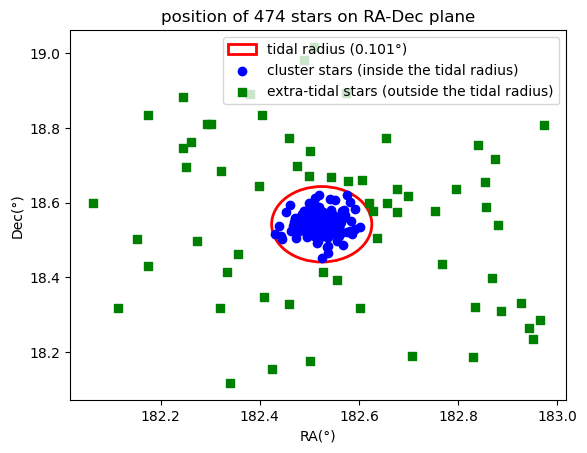

Total number of selected stars: 474 
Total number of cluster stars: 411 
Total number of extra-tidal stars: 63 


In [11]:
# Create a circle patch
circle = Circle(circle_center, radius, color='r', fill=False, linewidth=2, label='tidal radius (0.101°)')

# Add the circle to the plot
plt.gca().add_patch(circle)
plt.scatter(df1['ra'],df1['dec'],marker='o',color='b',label='cluster stars (inside the tidal radius)')
plt.scatter(df2['ra'],df2['dec'],marker='s',color='g',label='extra-tidal stars (outside the tidal radius)')
plt.xlabel('RA(°)')
plt.ylabel('Dec(°)')
plt.title('position of 474 stars on RA-Dec plane')
plt.legend()
plt.show()

N = len(df)
n1=len(df1)
n2=len(df2)
print(f'Total number of selected stars: {N} ')
print(f'Total number of cluster stars: {n1} ')
print(f'Total number of extra-tidal stars: {n2} ')

### Membership Probability <a name = 'h43'><a>

Membership probability refers to the likelihood that a star near a globular cluster belongs to it, rather than being a field star. Analyzing membership probabilities is an extremely crucial step in the process of selecting extra-tidal stars as this helps to identify which stars are genuinely part of the cluster’s gravitational system.

We used the maximum likelihood method, based on a Bayesian approach, applied to stars selected by proper motion.

### Probability Density Functions (p.d.f.)

1) For Cluster stars:  
$$
\phi^{\nu}_{c} = \frac{1}{2\pi \sqrt{(\sigma_c^2 + \epsilon_{xi}^2)(\sigma_c^2 + \epsilon_{yi}^2)}} \times \exp\left(-\frac{1}{2} \left[
        \frac{(\mu_{xi} - \mu_{xc})^2}{\sigma_c^2 + \epsilon_{xi}^2} +
        \frac{(\mu_{yi} - \mu_{yc})^2}{\sigma_c^2 + \epsilon_{yi}^2}
    \right] \right)
$$


where ($\mu_{xi}$, $\mu_{yi}$) are the proper motion of the ith star in the RA and Dec directions, 
($\epsilon_{xi}$, $\epsilon_{yi}$) are observational errors in proper motion for the ith star, ($\mu_{xc}$, $\mu_{yc}$) are the mean proper motion of the cluster in the RA and Dec directions.

---

2) For Field stars (Stars that lie outside the tidal radius):  
$$
\phi^{\nu}_{f} = \frac{1}{2\pi \sqrt{(1 - \gamma^2)(\sigma_{xf}^2 + \epsilon_{xi}^2)(\sigma_{yf}^2 + \epsilon_{yi}^2)}} \\
\times \exp \left( -\frac{1}{2(1 - \gamma^2)} \left[
    \frac{(\mu_{xi} - \mu_{xf})^2}{\sigma_{xf}^2 + \epsilon_{xi}^2}
    - \frac{2\gamma(\mu_{xi} - \mu_{xf})(\mu_{yi} - \mu_{yf})}
           {\sqrt{(\sigma_{xf}^2 + \epsilon_{xi}^2)(\sigma_{yf}^2 + \epsilon_{yi}^2)}}
    + \frac{(\mu_{yi} - \mu_{yf})^2}{\sigma_{yf}^2 + \epsilon_{yi}^2}
  \right] \right)
$$

where $\gamma$ is the correlation coefficient defined as:  
$$
  \gamma = \frac{(\mu_{xi} - \mu_{xf})(\mu_{yi} - \mu_{yf})}{\sigma_{xf} \sigma_{yf}} 
  \label{gamma}
$$

($\mu_{xf}$, $\mu_{yf}$ ) are the mean proper motion of the field stars in the RA and DEC directions, and ($\sigma_{xf}$, $\sigma_{yf}$) are the dispersion of the proper field motion. We will calculate these parameters using the Gaussian fit for field stars (here, the stars that lie outside the tidal radius are considered field stars). 

---

Intrinsic dispersion of the cluster’s proper motion:
$$
\sigma_c = \frac{\sigma_v}{R_\odot} 
$$

- $\sigma_v$ (central velocity dispersion) = 0.00000265723093 pc $\text{yr}^{-1}$ 
- $R_\odot$ (distance of the cluster from the sun) = 19300 pc (taken from Harris Catalog).

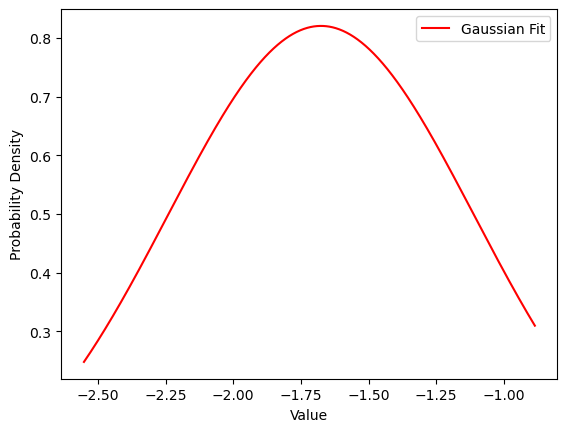

Fitted Parameters for pmra:
Mean_pmra: -1.6757270900902759
Standard_Deviation_pmra (Sigma): 0.5660156331301537


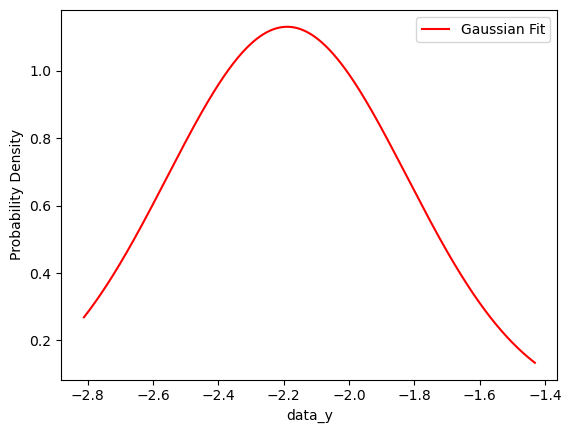

Fitted Parameters for pmdec:
Mean_pmra: -2.1894447170013347
Standard_Deviation_pmra (Sigma): 0.3665860938496067


In [12]:
import math
from scipy.stats import norm
from scipy.optimize import curve_fit
df=pd.read_csv('NGC4147_gaia_dr3_corrected_filtered_file.csv')
df1=pd.read_csv('NGC4147_cluster_stars.csv')
df2=pd.read_csv('NGC4147_extratidal_stars.csv')

############################ GAUSSIAN FIT FOR EXTRA-TIDAL STARS HAS TO BE DONE(TO FIND mu_x,sigma_x,mu_y,sigma_y) ###################################


data_x = df2['pmra'].dropna()
data_y = df2['pmdec'].dropna()

# Create a histogram with 50 bins
counts_x, bin_edges_x = np.histogram(data_x, bins=50, density=True)
counts_y, bin_edges_y = np.histogram(data_y, bins=50, density=True)

bin_centers_x = (bin_edges_x[:-1] + bin_edges_x[1:]) / 2
bin_centers_y = (bin_edges_y[:-1] + bin_edges_y[1:]) / 2

# Define a Gaussian function
def gaussian(x, mean, stddev, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

# Initial guess for the parameters: mean, standard deviation, and amplitude
initial_guess_x = [np.mean(data_x), np.std(data_x), np.max(counts_x)]
initial_guess_y = [np.mean(data_y), np.std(data_y), np.max(counts_y)]

# Fit the Gaussian function to the histogram data
params_x, covariance_x = curve_fit(gaussian, bin_centers_x, counts_x, p0=initial_guess_x)
mu_x, sigma_x, amplitude_x = params_x

params_y, covariance_y = curve_fit(gaussian, bin_centers_y, counts_y, p0=initial_guess_y)
mu_y, sigma_y, amplitude_y = params_y

x_range = np.linspace(min(data_x), max(data_x), 1000)
plt.plot(x_range, gaussian(x_range, *params_x), 'r-', label='Gaussian Fit')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

print("Fitted Parameters for pmra:")
print(f"Mean_pmra: {mu_x}")
print(f"Standard_Deviation_pmra (Sigma): {sigma_x}")

# Plot the Gaussian fit
y_range = np.linspace(min(data_y), max(data_y), 1000)
plt.plot(y_range, gaussian(y_range, *params_y), 'r-', label='Gaussian Fit')
plt.xlabel('data_y')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

print("Fitted Parameters for pmdec:")
print(f"Mean_pmra: {mu_y}")
print(f"Standard_Deviation_pmra (Sigma): {sigma_y}")

### Calculating Membership Probability
The membership probability for the $i$th star is:
$$
    P(i)= \frac{n_{c}\phi^{\nu}_{c}}{\phi^{\nu}} \label{mem_prob P(i)}
$$
The total distribution function ($\phi^{\nu}$) is:
$$
    \phi^{\nu}=n_{c}\phi^{\nu}_{c}+n_{f}\phi^{\nu}_{f} \label{total pdf}
$$
Here, $n_{c}$ and $n_{f}$ are the normalized number of cluster stars and extra-tidal stars.

C:\Users\hp\New folder\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SOURCE_ID                      63 non-null     int64  
 1   ra                             63 non-null     float64
 2   dec                            63 non-null     float64
 3   parallax                       63 non-null     float64
 4   pmra                           63 non-null     float64
 5   pmdec                          63 non-null     float64
 6   pmra_error                     63 non-null     float64
 7   pmdec_error                    63 non-null     float64
 8   ruwe                           63 non-null     float64
 9   astrometric_excess_noise_sig   63 non-null     float64
 10  astrometric_gof_al             63 non-null     float64
 11  visibility_periods_used        63 non-null     int64  
 12  phot_bp_rp_excess_factor       63 non-null     float

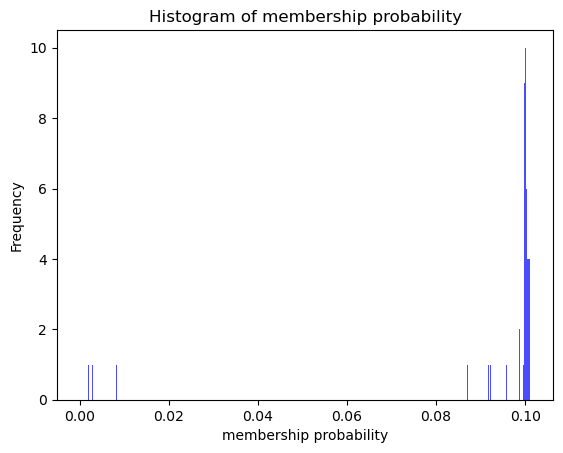

In [13]:
###################################################################################################################################################

# no.of stars
N = len(df)
n1=len(df1)
n2=len(df2)
#cluster pmra=-1.71
#cluster pmdec=-2.08
#central velocity dispersion (for cluster)= 2.6 km/sec = 0.00000265723093  pc/yr  (sigma_v)  1km=3.2407792896664E-14 pc     1sec=3.17098e-8 year
#distance of cluster from sun= 19.3 kpc   (R_sun)      1pc=206265 AU
pi=math.pi
sigma_v= 0.00000265723093
R_sun= 19300
sigma_c=sigma_v/R_sun   # intrinsic propre motion dispersion of cluster member stars
#df['gm']=((df['pmra']-mu_x)*(df['pmdec']-mu_y))/(sigma_x*sigma_y)
df2['gm']=((df2['pmra']-mu_x)*(df2['pmdec']-mu_y))/(sigma_x*sigma_y)

def Fc(n1,N,x,y,delta_x,delta_y,sigma_c):
 return ((n1/N)*(0.5/pi)*(1/(np.sqrt((sigma_c**2+delta_x**2)*(sigma_c**2+delta_y**2))))*np.exp(-0.5*(((x-(-1.71))**2/(sigma_c**2+delta_x**2))+((y-(-2.08))**2/(sigma_c**2+delta_y**2)))))

def Ff(n2,N,x,y,delta_x,delta_y,mu_x,mu_y,sigma_x,sigma_y,gm):
  return ((n2/N)*(1/(2*pi*np.sqrt(1-gm**2)))*(1/(np.sqrt((sigma_x**2+delta_x**2)*(sigma_y**2+delta_y**2))))*np.exp((-0.5/(1-gm**2))*(((x-mu_x)**2/(sigma_x**2+delta_x**2))-(2*gm*(x-mu_x)*(y-mu_y)/np.sqrt((sigma_x**2+delta_x**2)*(sigma_y**2+delta_y**2)))+((y-mu_y)**2/(sigma_y**2+delta_y**2)))))

def F(n1,n2,N,x,y,delta_x,delta_y,sigma_c,mu_x,mu_y,sigma_x,sigma_y,gm):
  return (((n1/N)*((1/2*pi)*(1/np.sqrt((sigma_c**2+delta_x**2)*(sigma_c**2+delta_y**2)))*(np.exp(-0.5*(((x-(-1.71))**2/(sigma_c**2+delta_x**2))+((y-(-2.08))**2/(sigma_c**2+delta_y**2)))))))+ ((n2/N)*(1/(2*pi*np.sqrt(1-gm**2)))*(1/np.sqrt((sigma_x**2+delta_x**2)*(sigma_y**2+delta_y**2)))*(np.exp((-0.5/(1-gm**2))*(((x-mu_x)**2/(sigma_x**2+delta_x**2))-((2*gm*(x-mu_x)*(y-mu_y))/np.sqrt((sigma_x**2+delta_x**2)*(sigma_y**2+delta_y**2)))+(((y-mu_y)**2)/(sigma_y**2+delta_y**2)))))))

#df['Mem_Prob']= Fc(n1,N,df['pmra'],df['pmdec'],df['pmra_error'],df['pmdec_error'],sigma_c)/F(n1,n2,N,df['pmra'],df['pmdec'],df['pmra_error'],df['pmdec_error'],sigma_c,mu_x,mu_y,sigma_x,sigma_y,df['gm'])
#df.to_csv('NGC4147_total_stars_memprob.csv', index=False)

 #df1['Mem_Prob']= Fc(n1,N,df1['pmra'],df1['pmdec'],df1['pmra_error'],df1['pmdec_error'],sigma_c)/mem_prob(n1,n2,N,df1['pmra'],df1['pmdec'],df1['pmra_error'],df1['pmdec_error'],sigma_c,mu_x,mu_y,sigma_x,sigma_y,df1['gm'])
# df1.to_csv('NGC4147_cluster_stars_memprob.csv', index=False)

df2['Mem_Prob']= Fc(n1,N,df2['pmra'],df2['pmdec'],df2['pmra_error'],df2['pmdec_error'],sigma_c)/F(n1,n2,N,df2['pmra'],df2['pmdec'],df2['pmra_error'],df2['pmdec_error'],sigma_c,mu_x,mu_y,sigma_x,sigma_y,df2['gm'])
df2.to_csv('NGC4147_extra_tidal_stars_memprob.csv', index=False)

#print(df.info())
#print(df.head())
# # print(df1.info())
# # print(df1.head())
print(df2.info())
print(df2.head())

plt.hist(df2['Mem_Prob'], bins=500, color='blue', alpha=0.7)
plt.title('Histogram of membership probability')
plt.xlabel('membership probability')
plt.ylabel('Frequency')
plt.show()

#plt.hist(values, bins=50, density=True, alpha=0.6, color='g', label='Data')

In [14]:
import pandas as pd

cluster_df = pd.read_csv('NGC4147_cluster_stars_memprob.csv')
df = pd.read_csv('NGC4147_extra_tidal_stars_memprob.csv')  # Adjust the file path and type as needed

# filter star having memprob >= 10%
filtered_df = df[(df['Mem_Prob'] >= 0.10)]
filtered_df.to_csv('extra-tidal_filtered.csv', index=False)  # Save as CSV, change as needed
print(len(filtered_df))

29


The extra-tidal stars are reduced from **63** to **29**.

In [15]:
#Append the filtered data to the original data.
combined_df = pd.concat([cluster_df, filtered_df], ignore_index=True)

combined_df.to_csv('NGC4147_TotalStars_filtered.csv', index=False)  # Save as new file
print(combined_df.info())
print(combined_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SOURCE_ID                      440 non-null    int64  
 1   ra                             440 non-null    float64
 2   dec                            440 non-null    float64
 3   parallax                       440 non-null    float64
 4   pmra                           440 non-null    float64
 5   pmdec                          440 non-null    float64
 6   pmra_error                     440 non-null    float64
 7   pmdec_error                    440 non-null    float64
 8   ruwe                           440 non-null    float64
 9   astrometric_excess_noise_sig   440 non-null    float64
 10  astrometric_gof_al             440 non-null    float64
 11  visibility_periods_used        440 non-null    int64  
 12  phot_bp_rp_excess_factor       411 non-null    flo

### Plotting Color-Magnitude Diagram <a name = 'h44'><a>

### What is Color-Magnitude Diagram?
The CMD is an observational version of the Hertzsprung–Russell diagram, using apparent magnitude and color instead of luminosity and temperature. CMDs are especially useful when luminosity or temperature cannot be measured directly. Color (e.g., Bp–Rp) acts as a proxy for temperature, while magnitude (e.g., G) relates to brightness.

<img src="https://www.researchgate.net/profile/Matthias_Bartelmann/publication/263367070/figure/fig2/AS:669092797231112@1536535562731/Hertzsprung-Russell-or-colour-magnitude-diagram-of-the-globular-cluster-M-68-The_W640.jpg" width="30%">

The Gaia satellite provides photometry in G, Bp, and Rp bands, allowing astronomers to build CMDs for millions of stars. It reveals stellar evolutionary features which are main sequence, red giant branch, horizontal branch, asymptotic branch and blue stragglers.
The main sequence turn-off point helps estimate a cluster’s age. They also assist in identifying cluster members and estimating distance.

### 1) Correcting for extinction
The space between the radiation source and the observer is not completely empty but contains some interstellar medium, so part of the radiation is absorbed by the medium (and usually reemitted at a different wavelength, which maybe outside the band defining the magnitude), or scattered away from the line of sight. All these radiation losses are
called the extinction.



For Extinction Correction, the equations used are:

\begin{align*}
    G_0 &= G - R_G \times 3.1 \times E(B - V) \\
    (G_{BP} - G_{RP})_0 &= (G_{BP} - G_{RP}) - (R_{BP} - R_{RP}) \times 3.1 \times E(B - V)
\end{align*}


In [16]:
# ========== Load your Gaia EDR3 observed cluster data ==========
# Replace with your actual file path if needed
obs_data = pd.read_csv("NGC4147_cluster_stars.csv")


# ========== Estimate median BP-RP color ==========
bp_rp_median = obs_data["bp_rp"].median()
print(f"Median (BP - RP) color of cluster: {bp_rp_median:.3f}")

# ========== Apply Gaia EDR3 COD extinction law ==========
# Table B1: Coefficients for Gaia EDR3 COD extinction law

# R_G = 3.071 - 0.511*(BP-RP) + 0.058*(BP-RP)^2
RG = 3.071 - 0.511 * bp_rp_median + 0.058 * (bp_rp_median**2)

# R_BP = 3.526 - 0.168*(BP-RP) - 0.170*(BP-RP)^2
RBP = 3.526 - 0.168 * bp_rp_median - 0.170 * (bp_rp_median**2)

# R_RP = 2.062 - 0.072*(BP-RP)
RRP = 2.062 - 0.072 * bp_rp_median

print(f"Computed Gaia EDR3 extinction coefficients (COD law):")
print(f"  R_G   = {RG:.3f}")
print(f"  R_BP  = {RBP:.3f}")
print(f"  R_RP  = {RRP:.3f}")

Median (BP - RP) color of cluster: 0.737
Computed Gaia EDR3 extinction coefficients (COD law):
  R_G   = 2.726
  R_BP  = 3.310
  R_RP  = 2.009


### 2) Plotting CMD 

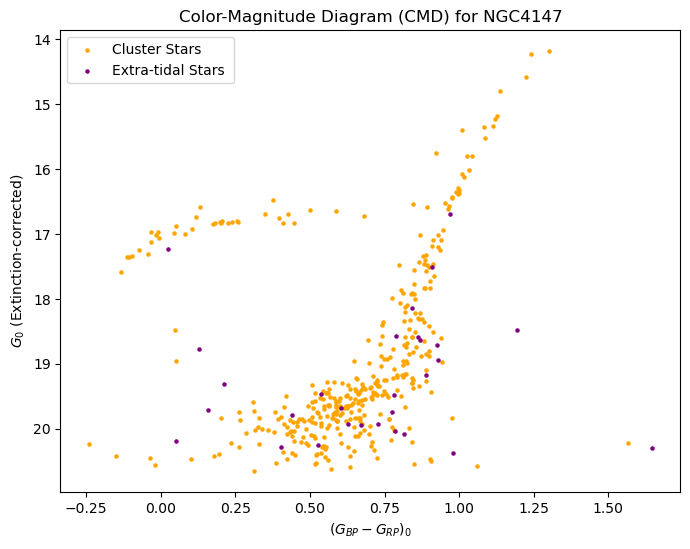

In [17]:
df=pd.read_csv('NGC4147_TotalStars_filtered.csv')
df1=pd.read_csv('NGC4147_cluster_stars_memprob.csv')
df2=pd.read_csv('extra-tidal_filtered.csv')
## Formulas applied:
#Go=G-Rg*3.1*E(B-V)
#(Gbp-Grp)o=(Gbp-Grp)-(Rbp-Rrp)*3.1*E(B-V)

## Extinction Coefficients:
Ebv = 0.02  # From Harris Catalog
Rg = 2.726   # Extinction coefficient for G-band
Rbp = 3.310  # Extinction coefficient for BP-band
Rrp = 2.009  # Extinction coefficient for RP-band


df['G0']=df['phot_g_mean_mag'] - Rg*3.1*Ebv
df['(Gbp-Grp)0']=df['bp_rp']-(Rbp-Rrp)*3.1*Ebv
df1['G0']=df1['phot_g_mean_mag']-Rg*3.1*Ebv
df1['(Gbp-Grp)0']=df1['bp_rp']-(Rbp-Rrp)*3.1*Ebv
df2['G0']=df2['phot_g_mean_mag']-Rg*3.1*Ebv
df2['(Gbp-Grp)0']=df2['bp_rp']-(Rbp-Rrp)*3.1*Ebv

# Plotting the CMD (Color-Magnitude Diagram)
plt.figure(figsize=(8, 6))
plt.scatter(df1['(Gbp-Grp)0'], df1['G0'], label="Cluster Stars", color="orange",s=5)
plt.scatter(df2['(Gbp-Grp)0'], df2['G0'], label="Extra-tidal Stars ", color="purple",s=5)

plt.gca().invert_yaxis()
plt.xlabel(r"$(G_{BP} - G_{RP})_0$")
plt.ylabel(r"$G_0$ (Extinction-corrected)")
plt.title('Color-Magnitude Diagram (CMD) for NGC4147')
plt.legend()
plt.show()

### Performing Isochrone fitting for estimating the age, metallicity and selecting the likely extra-tidal candidates of the Cluster <a name = 'h45'><a>

### What are stellar isochrones?

In stellar evolution, an isochrone is a curve on the Hertzsprung-Russell diagram, representing a population of stars of the same age but with different mass.

Isochrone fitting involves comparing theoretical stellar evolution tracks with observed CMDs. We selected 6 isochrone models from PARSEC database each with varying:
- **Age** (in log(Age/yr))
- **Metallicity** ([Fe/H] in dex)

Each isochrone represents a population of stars with specific age and chemical composition. PARSEC models provide apparent magnitudes in Gaia $G$, $G_{BP}$, and $G_{RP}$ bands, which will be further corrected for extinction and distance modulus.

### Fitting Methodology
Each isochrone is tested against the observed CMD of NGC 4147 by applying a trial distance modulus (DM) and minimizing the average squared distance between isochrone points and cluster stars in CMD space:

1) Correct Gaia magnitudes for extinction and apply a trial distance modulus:
    \begin{align*}
        G_{\text{fit}} = G_0 + DM
    \end{align*}

2) Define a cost function using the average squared distance between isochrone and observed points:
    \begin{align*}
        \chi^2 = \frac{1}{N} \sum_i \min_j \left[ (c_i - c_j)^2 + (m_i - m_j)^2 \right]
    \end{align*}
    where $(c_i, m_i)$ are isochrone color–magnitude pairs and $(c_j, m_j)$ are observed stars.


3) Alternatively,
    \begin{align*}
        \chi^2 = \min \left[ (G^{\text{obs}}_0 - (G^{\text{iso}}_0 + DM))^2 + ((BP - RP)_0^{\text{obs}} - (BP - RP)_0^{\text{iso}})^2 \right]   
    \end{align*}

4) Use scipy.optimize.minimize from SciPy to find the DM that minimizes $\chi^2$.


The isochrone with the lowest $\chi^2$ is taken as the best fit.

The already selected **29** extra-tidal stars are compared with the best-fit isochrone, and those within ±0.1 mag in both color and magnitude are considered as the most likely extra-tidal stars of the cluster.


Final count of extra-tidal stars within ±0.1 mag of best-fit isochrone: 14


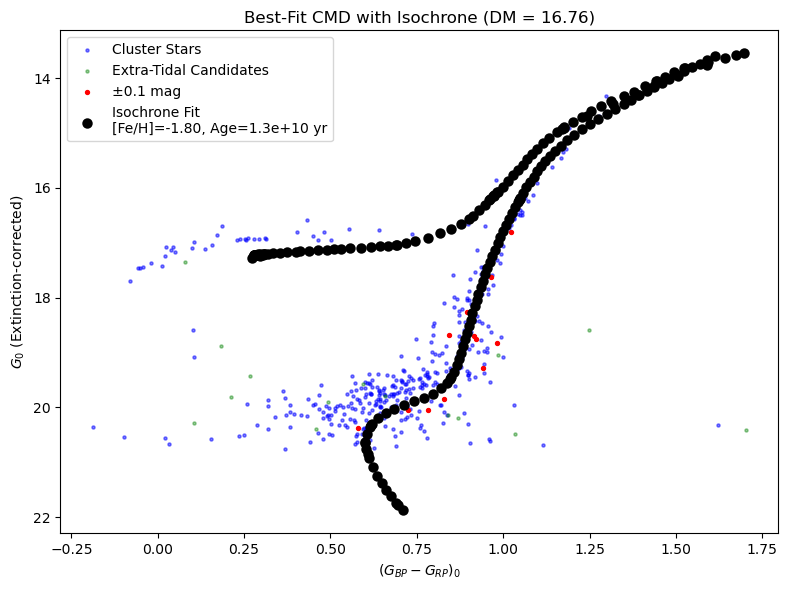

In [18]:
from scipy.optimize import minimize

# ========== Extinction Parameters ==========
Rg, Rbp, Rrp = 2.726, 3.310, 2.009
Ebv = 0.02
mag_limit_min = 12
mag_limit_max = 22
color_tol = 0.1
mag_tol = 0.1

# ========== Load and Process Cluster Data ==========
cluster_df = pd.read_csv("NGC4147_cluster_stars_memprob.csv").dropna(subset=["bp_rp", "phot_g_mean_mag"])
cluster_df["bp_rp_0"] = cluster_df["bp_rp"] - (Rbp - Rrp) * Ebv
cluster_df["G0"] = cluster_df["phot_g_mean_mag"] - Rg * Ebv

# ========== Load and Process Extra-Tidal Data ==========
extra_df = pd.read_csv("extra-tidal_filtered.csv").dropna(subset=["bp_rp", "phot_g_mean_mag"])
extra_df["bp_rp_0"] = extra_df["bp_rp"] - (Rbp - Rrp) * Ebv
extra_df["G0"] = extra_df["phot_g_mean_mag"] - Rg * Ebv

# ========== Isochrone File List ==========
column_names = [
    "Zini", "MH", "logAge", "Mini", "int_IMF", "Mass", "logL", "logTe", "logg", "label",
    "McoreTP", "C_O", "period0", "period1", "period2", "period3", "period4", "pmode",
    "Mloss", "tau1m", "X", "Y", "Xc", "Xn", "Xo", "Cexcess", "Z", "mbolmag",
    "Gmag", "G_BPmag", "G_RPmag"
]

isochrone_files = [
    r"C:\Users\hp\Downloads\output11e91.75dat\output11e91.75dat.dat",
    r"C:\Users\hp\Downloads\output11e91.78.dat\output11e91.78.dat",
    r"C:\Users\hp\Downloads\output11e91.8.dat\output11e91.8.dat",
    r"C:\Users\hp\Downloads\output12e91.8.dat\output12e91.8.dat",
    r"C:\Users\hp\Downloads\output10e91.8.dat\output10e91.8.dat",
    r"C:\Users\hp\Downloads\output13e91.8\output13e91.8.dat"
]

fit_results = []

# ========== Fit Each Isochrone ==========
for path in isochrone_files:
    iso = pd.read_csv(path, sep=r"\s+", header=None, names=column_names, comment="#")

    logAge = iso["logAge"].values[0]
    age = 10 ** logAge
    MH = iso["MH"].values[0]

    BP_RP_0 = (iso["G_BPmag"] - iso["G_RPmag"]) - (Rbp - Rrp) * Ebv
    G0 = iso["Gmag"] - Rg * Ebv

    def match_distance(params):
        DM = params[0]
        Gcorr = G0 + DM
        valid = (Gcorr > mag_limit_min) & (Gcorr < mag_limit_max) & (BP_RP_0 > -0.75) & (BP_RP_0 < 2.5)
        if not np.any(valid): return 1e6

        iso_c = BP_RP_0[valid].values
        iso_m = Gcorr[valid].values

        total_dist = 0
        for c, m in zip(iso_c, iso_m):
            d2 = (cluster_df["bp_rp_0"] - c) ** 2 + (cluster_df["G0"] - m) ** 2
            total_dist += np.min(d2)
        return total_dist / len(iso_c)

    result = minimize(match_distance, [16.0], bounds=[(10, 20)])
    DM_best = result.x[0]
    score = result.fun

    fit_results.append({
        "MH": MH,
        "logAge": logAge,
        "age": age,
        "DM": DM_best,
        "score": score,
        "BP_RP": BP_RP_0,
        "Gmag": G0 + DM_best
    })

# ========== Get Best-Fit Isochrone ==========
best_fit = min(fit_results, key=lambda x: x["score"])
valid = (best_fit["Gmag"] > mag_limit_min) & (best_fit["Gmag"] < mag_limit_max)

iso_color = best_fit["BP_RP"][valid].values
iso_mag = best_fit["Gmag"][valid].values

# ========== Select Extra-Tidal Stars Near Best Isochrone ==========
extra_selected = []
for i, star in extra_df.iterrows():
    diff_color = np.abs(iso_color - star["bp_rp_0"])
    diff_mag = np.abs(iso_mag - star["G0"])
    if np.any((diff_color <= color_tol) & (diff_mag <= mag_tol)):
        extra_selected.append(star)

extra_selected_df = pd.DataFrame(extra_selected)
print(f"\nFinal count of extra-tidal stars within ±0.1 mag of best-fit isochrone: {len(extra_selected_df)}")

# ========== Final CMD Plot ==========
plt.figure(figsize=(8, 6))
plt.scatter(cluster_df["bp_rp_0"], cluster_df["G0"], s=5, color='blue', alpha=0.5, label="Cluster Stars")
plt.scatter(extra_df["bp_rp_0"], extra_df["G0"], s=5, color='green', alpha=0.4, label="Extra-Tidal Candidates")
plt.scatter(extra_selected_df["bp_rp_0"], extra_selected_df["G0"], s=8, color='red', label="±0.1 mag")

plt.scatter(iso_color, iso_mag, color='black', linewidth=1.5, label=f"Isochrone Fit\n[Fe/H]={best_fit['MH']:.2f}, Age={best_fit['age']:.1e} yr")
plt.gca().invert_yaxis()
plt.xlabel(r"$(G_{BP} - G_{RP})_0$")
plt.ylabel(r"$G_0$ (Extinction-corrected)")
plt.title(f"Best-Fit CMD with Isochrone (DM = {best_fit['DM']:.2f})")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# ========== Save Selected Extra-Tidal Stars ==========
output_path = "selected_extra_tidal_stars.csv"
extra_selected_df.to_csv(output_path, index=False)
print(f"Selected extra-tidal stars saved to: {output_path}")


Selected extra-tidal stars saved to: selected_extra_tidal_stars.csv


The best-fitting isochrone directly provides estimates of the cluster’s:
1) Age, inferred from the position of the main sequence turnoff and subgiant branch. From the best-fit model, the age of NGC 4147 is estimated to be **(1.3 ± 0.2) × $10^{10}$** years.
2) Metallicity, is inferred from the slope and shape of the red giant branch and other CMD features. The corresponding metallicity is found to be [Fe/H] = **−1.8 dex**.
3) A total of **14** extra-tidal stars were found to lie along the best-fit isochrone.


### Plotting the Density Map <a name = 'h46'><a>

The density map of the selected extra-tidal candidates ($N_{extra−tidal}$), along with the proper
motion direction, $r_{t}$ and $5r_{t}$ of the cluster is to be drawn, for a total of 14 extra-tidal star candidates.

The density maps is to be created using the kernel density estimator (KDE) routine of the scipy module. The bandwidth used for Gaussian KDE is 7.43 arc min.  

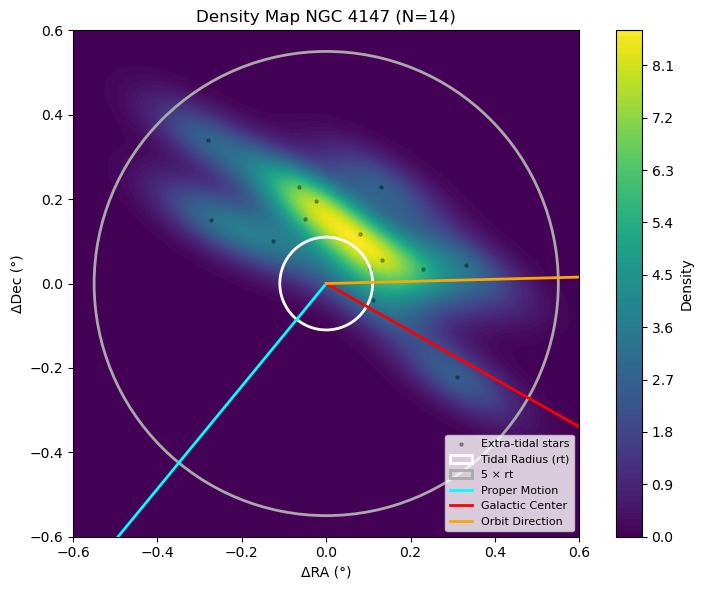

In [20]:
from scipy.stats import gaussian_kde

# === Load Data ===
cluster_df = pd.read_csv("NGC4147_cluster_stars_memprob.csv")
extra_df = pd.read_csv("selected_extra_tidal_stars.csv")

# Drop NaNs
cluster_df = cluster_df.dropna(subset=["ra", "dec"])
extra_df = extra_df.dropna(subset=["ra", "dec"])

# === Cluster Center ===
cluster_center_ra = cluster_df["ra"].mean()
cluster_center_dec = cluster_df["dec"].mean()

# === ΔRA, ΔDec (degrees) ===
delta_ra = extra_df["ra"] - cluster_center_ra
delta_dec = extra_df["dec"] - cluster_center_dec

# === 2D KDE with fixed bandwidth of 7.43 arcmin ===
xy = np.vstack([delta_ra, delta_dec])
desired_bw_deg = 7.43 / 60  # Convert arcmin to degrees
kde = gaussian_kde(xy)
# Override the bandwidth
kde.set_bandwidth(bw_method=kde.factor * (desired_bw_deg / np.std(xy, axis=1).mean()))

# Set radius in degrees
rt = 6.6 / 60  # arcmin to degrees
rmax = 5 * rt

# KDE grid
grid_buffer = 0.05
xlim = [-rmax - grid_buffer, rmax + grid_buffer]
ylim = [-rmax - grid_buffer, rmax + grid_buffer]
xgrid = np.linspace(xlim[0], xlim[1], 300)
ygrid = np.linspace(ylim[0], ylim[1], 300)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6))

# Density background
density_plot = ax.contourf(X, Y, Z, levels=100, cmap="viridis")
cbar = plt.colorbar(density_plot, ax=ax)
cbar.set_label("Density")

# Extra-tidal stars
ax.scatter(delta_ra, delta_dec, s=5, c="black", alpha=0.3, label="Extra-tidal stars")

# Tidal radius circles
circle1 = plt.Circle((0, 0), rt, color='white', fill=False, linestyle='-', linewidth=2, label='Tidal Radius (rt)')
circle5 = plt.Circle((0, 0), 5 * rt, color='darkgrey', fill=False, linestyle='-', linewidth=2, label='5 × rt')
ax.add_patch(circle1)
ax.add_patch(circle5)

# === Proper Motion Line ===
pmra, pmdec = -1.71, -2.08
pm_mag = np.sqrt(pmra**2 + pmdec**2)
unit_dx, unit_dy = pmra / pm_mag, pmdec / pm_mag
max_extent = np.sqrt(xlim[1]**2 + ylim[1]**2)
dx_pm, dy_pm = unit_dx * max_extent, unit_dy * max_extent
ax.plot([0, dx_pm], [0, dy_pm], color='cyan', linewidth=2, label='Proper Motion')

# === Galactic Center Line ===
ra_gc, dec_gc = 266.4051, -28.936175
delta_ra_gc = ra_gc - cluster_center_ra
delta_dec_gc = dec_gc - cluster_center_dec
gc_mag = np.sqrt(delta_ra_gc**2 + delta_dec_gc**2)
unit_gc_ra = delta_ra_gc / gc_mag
unit_gc_dec = delta_dec_gc / gc_mag
dx_gc = unit_gc_ra * max_extent
dy_gc = unit_gc_dec * max_extent
ax.plot([0, dx_gc], [0, dy_gc], color='red', linewidth=2, label='Galactic Center')

# === Future Orbit Line ===
ra_future = 192.6
dec_future = 18.8
delta_ra_orbit = ra_future - cluster_center_ra
delta_dec_orbit = dec_future - cluster_center_dec
orbit_mag = np.sqrt(delta_ra_orbit**2 + delta_dec_orbit**2)
unit_orbit_ra = delta_ra_orbit / orbit_mag
unit_orbit_dec = delta_dec_orbit / orbit_mag
dx_orbit = unit_orbit_ra * max_extent
dy_orbit = unit_orbit_dec * max_extent
ax.plot([0, dx_orbit], [0, dy_orbit], color='orange', linewidth=2, label='Orbit Direction')

# Formatting
ax.set_xlabel("ΔRA (°)")
ax.set_ylabel("ΔDec (°)")
ax.set_title("Density Map NGC 4147 (N=14)")
ax.set_aspect('equal')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()


Here, ∆RA is the difference between the RA of the extra-tidal star and the RA of the cluster, the same as for ∆Dec.
The plot shows the direction towards the galactic center (red line) and the orbit followed by the cluster in the future (orange line). The inner white circle and outer dark grey circle correspond to $r_{t}$ and $5r_{t}$, respectively. The contour lines represent the iso-density regions with a constant number of stars per square degree.

### Plotting the Orbit of the cluster <a name = 'h47'><a>

Using Gravpot 16 Web Interface, the data for orbit of the cluster forward and backward integrated over 5 Gyr is obtained.

### For Backward Integration

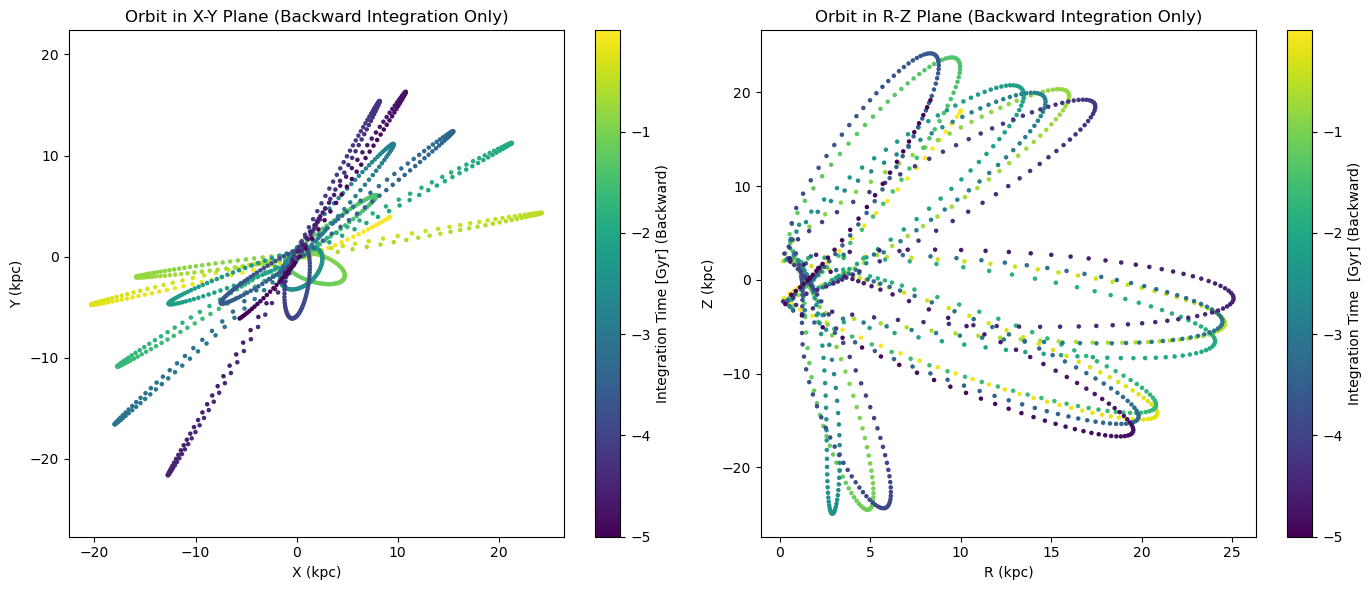

In [22]:
# Load the data, skipping the first row which contains headers
orbitbck_df = pd.read_csv('orbitbck.dat', delim_whitespace=True, skiprows=1, header=None)

orbitbck_df.columns = [
    'time', 'id', 'x', 'y', 'z', 'vx', 'vy', 'vz',
    'x_bar', 'y_bar', 'z_bar', 'vx_bar', 'vy_bar', 'vz_bar',
    'E_J', 'E_tot', 'Lz', 'Ltot', 'Incl', 'Phil', 'Pot', 'PotBar'
]

# Compute radial distance r = sqrt(x² + y²)
orbitbck_df['r'] = np.sqrt(orbitbck_df['x']**2 + orbitbck_df['y']**2)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 1. Orbit in x-y plane
sc1 = axs[0].scatter(orbitbck_df['x'], orbitbck_df['y'], c=orbitbck_df['time'], cmap='viridis', s=5)
axs[0].set_title("Orbit in X-Y Plane (Backward Integration Only)")
axs[0].set_xlabel("X (kpc)")
axs[0].set_ylabel("Y (kpc)")
axs[0].axis('equal')
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label("Integration Time [Gyr] (Backward)")

# 2. Orbit in r-z plane
sc2 = axs[1].scatter(orbitbck_df['r'], orbitbck_df['z'], c=orbitbck_df['time'], cmap='viridis', s=5)
axs[1].set_title("Orbit in R-Z Plane (Backward Integration Only)")
axs[1].set_xlabel("R (kpc)")
axs[1].set_ylabel("Z (kpc)")
cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_label("Integration Time  [Gyr] (Backward)")

plt.tight_layout()
plt.show()


### For Forward Integration

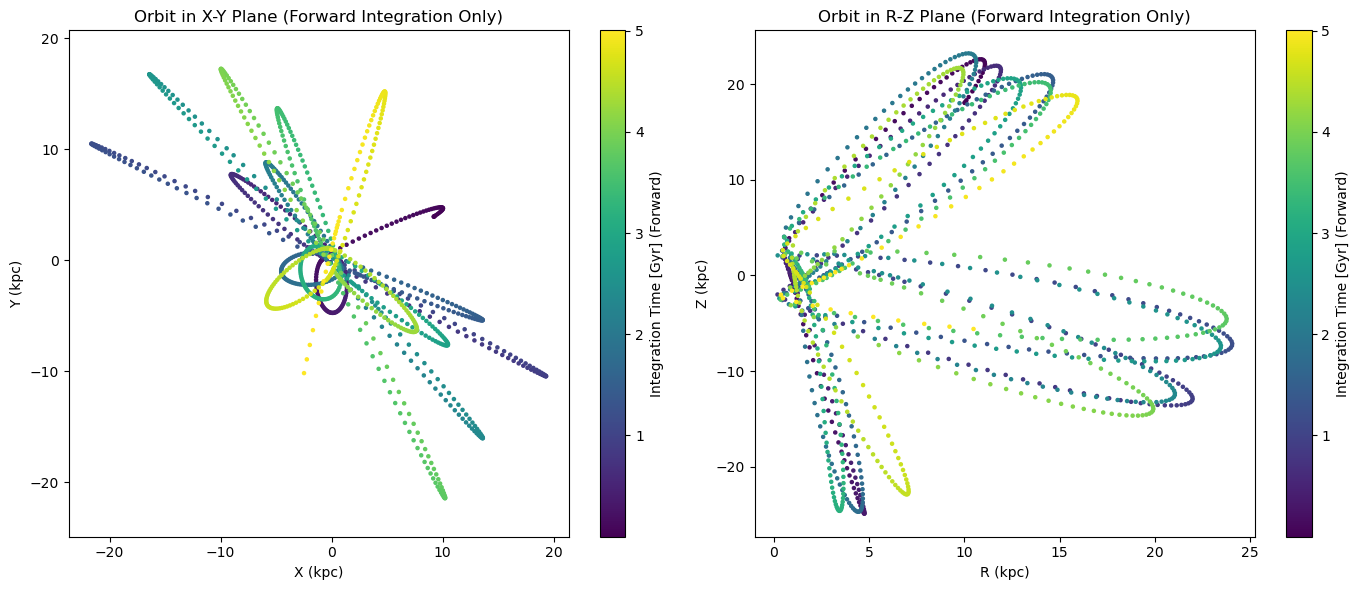

In [24]:
# Load the forward integration data
orbitfwd_df = pd.read_csv('orbit_fwd.dat', delim_whitespace=True, skiprows=1, header=None)

orbitfwd_df.columns = [
    'time', 'id', 'x', 'y', 'z', 'vx', 'vy', 'vz',
    'x_bar', 'y_bar', 'z_bar', 'vx_bar', 'vy_bar', 'vz_bar',
    'E_J', 'E_tot', 'Lz', 'Ltot', 'Incl', 'Phil', 'Pot', 'PotBar'
]

# Compute radial distance
orbitfwd_df['r'] = np.sqrt(orbitfwd_df['x']**2 + orbitfwd_df['y']**2)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 1. Orbit in x-y plane
sc1 = axs[0].scatter(orbitfwd_df['x'], orbitfwd_df['y'], c=orbitfwd_df['time'], cmap='viridis', s=5)
axs[0].set_title("Orbit in X-Y Plane (Forward Integration Only)")
axs[0].set_xlabel("X (kpc)")
axs[0].set_ylabel("Y (kpc)")
axs[0].axis('equal')
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label("Integration Time [Gyr] (Forward)")

# 2. Orbit in r-z plane
sc2 = axs[1].scatter(orbitfwd_df['r'], orbitfwd_df['z'], c=orbitfwd_df['time'], cmap='viridis', s=5)
axs[1].set_title("Orbit in R-Z Plane (Forward Integration Only)")
axs[1].set_xlabel("R (kpc)")
axs[1].set_ylabel("Z (kpc)")
cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_label("Integration Time [Gyr] (Forward)")

plt.tight_layout()
plt.show()

These plots shows that the cluster NGC 4147 has passed through the Galactic disk many times and will continue to do so in the future. This is the possible reason for shocks experienced by the cluster, which results as the tidal disruption by the matter in the galactic disk leading to the presence of extra-tidal stars in the cluster.

## Conclusions <a name = 'h5'><a>

1) We estimated the age and metallicity of NGC 4147 to be:
- (1.3 ± 0.2) × $10^{10}$ years
-  −1.8 dex

These values are based on CMD analysis and isochrone fitting, and are consistent with previous studies.

2) For selecting extra-tidal stars, we began with **2389** stars. After applying proper motion and CMD-based selection criteria, we shortlisted **425** probable members.

3) Among them, **14** stars were identified as the most likely extra-tidal candidates. This list may be incomplete, as some stars might have drifted beyond the $5r_{t}$ region and were not captured in our selection.

4) The density map reveals an **overdensity** of candidates in the direction opposite to the cluster’s proper motion. This suggests that they maybe more strongly affected by the gravitational potential of the Milky Way. 

5) Combined with the orbital analysis, NGC 4147 appears to have undergone repeated **disk** and/or **bulge crossings**.

5) These interactions likely caused tidal stripping of stars from the cluster’s outskirts, leading to the formation of **extended extra-tidal** features.


To conclude, the candidates identified in this study represent the most probable extra-tidal members based on currently available Gaia astrometry and photometry data. However, a definitive confirmation requires follow-up star-by-star analysis of their radial velocity measurements.